## Experimental notebook

This is a notebook where we explored the data, trained different models and experimented with different feature combinations. It's not part of the competition submission.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

## Clean Data imports

In [2]:
no_null_sales = pd.read_csv('clean_data.csv', parse_dates = True)
stores = pd.read_csv('stores_light.csv')

/opt/anaconda3/envs/minicomp/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Helper functions

In [39]:
def metric(preds, actuals):
    '''Given by competition organizers'''
    preds = preds.reshape(-1)
    actuals = actuals.reshape(-1)
    assert preds.shape == actuals.shape
    return 100 * np.linalg.norm((actuals - preds) / actuals) / np.sqrt(preds.shape[0])

def get_score(actuals, preds):
    '''Ensures no 0 sales get fed into metric function'''
    new_test= pd.DataFrame({'Actuals': actuals,'Preds': preds})
    new_test = new_test.loc[new_test['Actuals'] != 0,:]
    return metric(np.array(new_test['Actuals']), np.array(new_test['Preds']))

def mean_encoder(target_df, col, base_df=no_null_sales.copy(), target = 'Sales'):
    '''Simple mean encoder'''
    Mean_encoded_subject = base_df.groupby(col).mean()[target].to_dict() 
    return target_df[col].map(Mean_encoded_subject).values

## Exploratory Data Analysis

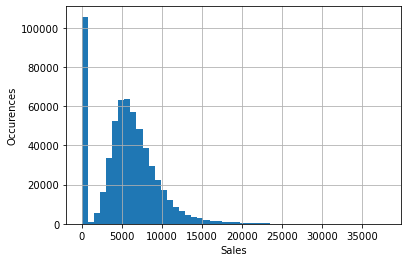

In [4]:
# Target column (Sales) distribution
no_null_sales.loc[:,'Sales'].hist(bins = 50)
plt.xlabel('Sales')
plt.ylabel('Occurences')
plt.show()

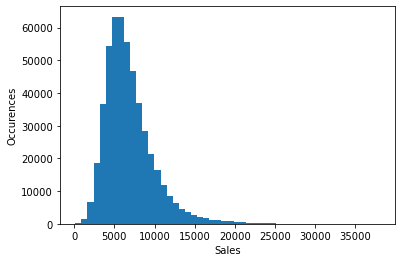

In [5]:
# Days with 0 Sales will not help our model
no_null_sales = no_null_sales.loc[no_null_sales.loc[:,'Sales'] > 0]
plt.hist(no_null_sales.loc[:,'Sales'],bins = 50)
plt.xlabel('Sales')
plt.ylabel('Occurences')
plt.show()

In [6]:
# Column overview
no_null_sales.head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
27,2013-01-01,353.0,2,3139.0,820.0,1.0,0.0,a,1.0
115,2013-01-01,335.0,2,2401.0,482.0,1.0,0.0,a,1.0
145,2013-01-01,512.0,2,2646.0,625.0,1.0,0.0,a,1.0
160,2013-01-01,494.0,2,3113.0,527.0,1.0,0.0,a,1.0
194,2013-01-01,530.0,2,2907.0,532.0,1.0,0.0,a,1.0


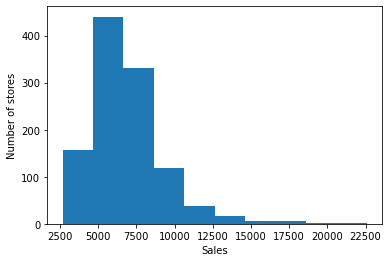

In [7]:
# Most stores average between 2500 and 10000 in daily sales. A few outliers average up to 22500. 
sales_by_store = no_null_sales.groupby('Store').mean().loc[:,'Sales'].sort_values(ascending=False)
plt.hist(sales_by_store.values)
plt.xlabel('Sales')
plt.ylabel('Number of stores')
plt.show()

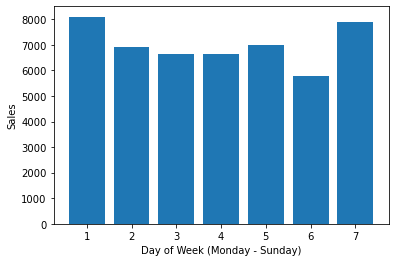

In [8]:
# Sales are highest on Mondays and Sundays
sales_by_weekday = no_null_sales.groupby('DayOfWeek').mean().loc[:,'Sales'].sort_values(ascending=False)
plt.bar(height=sales_by_weekday.values, x=sales_by_weekday.index)
plt.ylabel('Sales')
plt.xlabel('Day of Week (Monday - Sunday)')
plt.show()

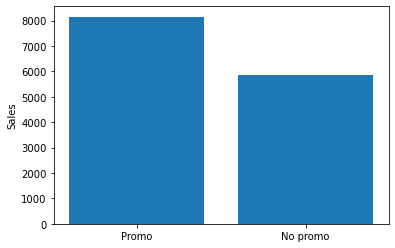

In [9]:
# Sales are much higher on days with promo
sales_by_promo = no_null_sales.groupby('Promo').mean().loc[:,'Sales'].sort_values(ascending=False)
plt.bar(height=sales_by_promo.values, x=[0,1])
plt.xticks([0,1], labels=['Promo', 'No promo'])
plt.ylabel('Sales')
plt.show()

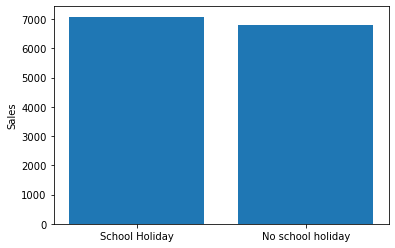

In [10]:
# School holidays make very little difference
sales_by_school_holiday = no_null_sales.groupby('SchoolHoliday').mean().loc[:,'Sales'].sort_values(ascending=False)
plt.bar(height=sales_by_school_holiday, x=[0,1])
plt.xticks([0,1], labels=['School Holiday', 'No school holiday'])
plt.ylabel('Sales')
plt.show()

In [11]:
no_null_sales.loc[no_null_sales['StateHoliday'] == 0, 'StateHoliday'] = '0'

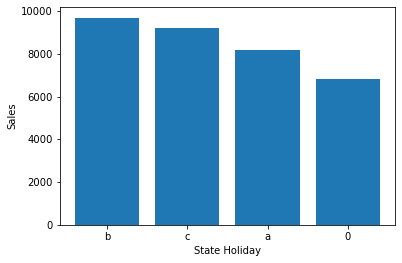

In [12]:
# State holidays seem to make a difference
sales_by_state_holiday = no_null_sales.groupby('StateHoliday').mean().loc[:,'Sales'].sort_values(ascending=False)
plt.bar(height=sales_by_state_holiday.values, x=sales_by_state_holiday.index)
plt.xlabel('State Holiday')
plt.ylabel('Sales')
plt.show()

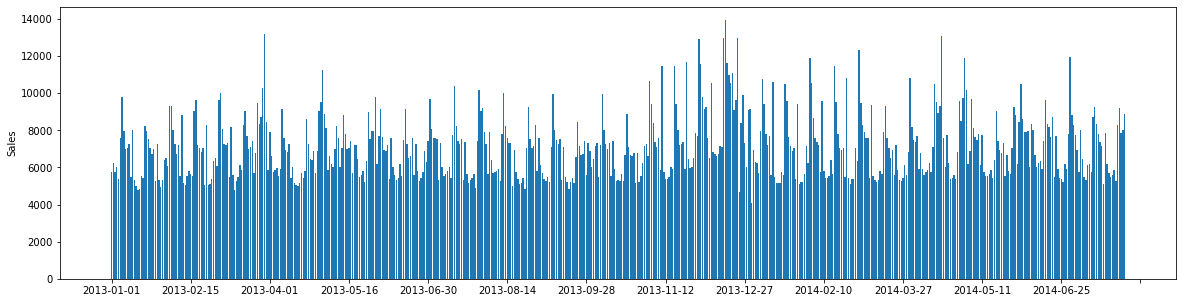

In [13]:
# In this sales timeline, there's a clear pattern repeating itself, and a slight uptick in sales in December
sales_by_date = no_null_sales.groupby('Date').mean().loc[:,'Sales']
plt.figure(figsize=(20,5))
plt.bar(height=sales_by_date.values, x=sales_by_date.index)
plt.xticks(range(0,600,45))
plt.ylabel('Sales')
plt.show()

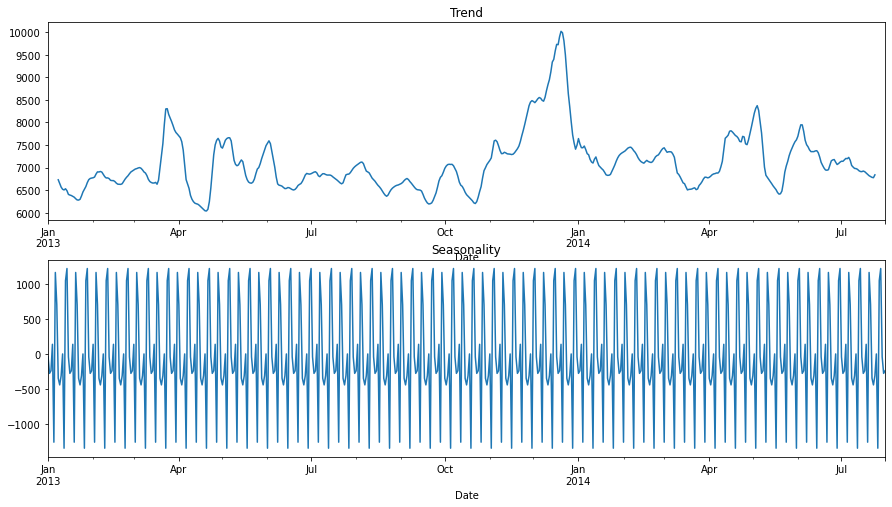

In [14]:
# Attempting to decompose it into Trend and Seasonality. There's weekly seasonality. 
# December has higher sales. 
# There also seems to be a biweekly seasonality - could - this be the promo feature?
from statsmodels.tsa.seasonal import seasonal_decompose
sales_by_date.index = pd.to_datetime(sales_by_date.index)
res = seasonal_decompose(sales_by_date, model='additive', period=14)
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(15,8))
ax1.set_title('Trend')
res.trend.plot(ax=ax1)
ax2.set_title('Seasonality')
res.seasonal.plot(ax=ax2)
plt.show()

## Baseline 1

Let's see how good a score we can get when just predicting the mean sales for each store

In [15]:
X = no_null_sales[['Store']]
y = no_null_sales['Sales']
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
lazy_est = pd.concat([X_train, y_train], axis=1)
lazy_est = lazy_est.groupby(['Store']).mean()
preds = X_test.merge(lazy_est, how = 'left', on = 'Store').loc[:, 'Sales']
actuals = np.array(y_test)
get_score(actuals, preds)

28.10451297005833

## Baseline 2
What it we take the mean for each store and weekday?

In [16]:
X = no_null_sales[['Store', 'DayOfWeek']]
y = no_null_sales['Sales']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
lazy_est = pd.concat([X_train, y_train], axis=1)
lazy_est = lazy_est.groupby(['Store', 'DayOfWeek']).mean()
preds = X_test.merge(lazy_est, how = 'left', on = ['Store', 'DayOfWeek']).loc[:, 'Sales']
actuals = np.array(y_test)
get_score(actuals, preds)

23.363506982930037

## Baseline 3

Promo also seemed important, what if we add it?

In [17]:
X = no_null_sales[['Store', 'DayOfWeek', 'Promo']]
y = no_null_sales['Sales']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
lazy_est = pd.concat([X_train, y_train], axis=1)
lazy_est = lazy_est.groupby(['Store', 'DayOfWeek', 'Promo']).mean()
preds = X_test.merge(lazy_est, how = 'left', on = ['Store', 'DayOfWeek', 'Promo']).loc[:, 'Sales']
actuals = np.array(y_test)
get_score(actuals, preds)

17.54769843922765

## Random Forest experiments

Surely a sophisticated Machine Learning model must beat our baseline?

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [19]:
# For quicker iteration speed, we'll work with a subset of 20 % of the data
sample = no_null_sales.sample(frac = 0.2, random_state = 42)

In [20]:
def run_random_forest(rf_set):
    X = rf_set.drop('Sales', axis = 1)
    y = rf_set['Sales']
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    actuals = np.array(y_test)
    return get_score(actuals, preds)

Generally in time series, we use the last part of our sequence as validation data. For example, if you have 12 months of data, you may train on the first 10 and validate on the last 2. In this case, we didn't do this. We used the general ML approach of picking out random samples. The reason is that the competition will ultimately be judged on 12 months of data. So if we validate on and optimize for 2 specific months, we run the risk of failing to accurately predict the remaining 10 months. One could argue for and against this approach. The beauty of working under time pressure is that we don't have time to argue right now. 

In [21]:
# Without promo, schoolHoliday and Stateholiday
rf_set = sample.drop(['Date', 'Customers', 'SchoolHoliday','StateHoliday', 'Promo'], axis = 1)
run_random_forest(rf_set)

24.288921773426495

In [22]:
# With Promo
rf_set = sample.drop(['Date', 'Customers', 'SchoolHoliday', 'StateHoliday'], axis = 1)
run_random_forest(rf_set)

18.68212215643297

In [23]:
# With State Holiday lazily encoded to 1 or 0
rf_set = sample.drop(['Date', 'Customers', 'SchoolHoliday'], axis = 1)
rf_set.loc[:,'StateHoliday'] = rf_set.loc[:,'StateHoliday'].apply(lambda x: 0 if x=='0' else 1)
run_random_forest(rf_set)

18.640023910645745

In [24]:
# With State Holiday mean encoded
rf_set = sample.drop(['Date', 'Customers', 'SchoolHoliday'], axis = 1)
rf_set['StateHoliday'] = mean_encoder(rf_set, 'StateHoliday')
run_random_forest(rf_set)

18.64623193915348

In [25]:
# With SchoolHoliday, and State Holiday lazily encoded to 1 or 0
rf_set = sample.drop(['Date', 'Customers'], axis = 1)
rf_set.loc[:,'StateHoliday'] = rf_set.loc[:,'StateHoliday'].apply(lambda x: 0 if x=='0' else 1)
run_random_forest(rf_set)

18.989837955933144

In [26]:
sample['Date'] = pd.to_datetime(sample['Date'])
sample['Month'] = sample['Date'].dt.month

In [27]:
# With Month 
rf_set = sample.drop(['Date', 'Customers', 'SchoolHoliday'], axis = 1)
rf_set.loc[:,'StateHoliday'] = rf_set.loc[:,'StateHoliday'].apply(lambda x: 0 if x=='0' else 1)
run_random_forest(rf_set)

22.452682850659013

In [28]:
# With month encoded to identify december (sales appear to be higher in december)
rf_set = sample.drop(['Date', 'Customers', 'SchoolHoliday'], axis = 1)
rf_set.loc[rf_set['Month'] != 12, 'Month'] = 0
rf_set.loc[rf_set['Month'] == 12, 'Month'] = 1
rf_set.loc[:,'StateHoliday'] = rf_set.loc[:,'StateHoliday'].apply(lambda x: 0 if x=='0' else 1)
run_random_forest(rf_set)

19.223571466230517

In [29]:
# Store mean-encoded
rf_set = sample.drop(['Date', 'Customers', 'SchoolHoliday', 'Month'], axis = 1)
rf_set['Store'] = mean_encoder(rf_set, 'Store')
rf_set.loc[:,'StateHoliday'] = rf_set.loc[:,'StateHoliday'].apply(lambda x: 0 if x=='0' else 1)
run_random_forest(rf_set)

18.605774331237455

In [30]:
#Weekday mean-encoded
rf_set = sample.drop(['Date', 'Customers', 'SchoolHoliday', 'Month'], axis = 1)
rf_set.loc[:,'StateHoliday'] = rf_set.loc[:,'StateHoliday'].apply(lambda x: 0 if x=='0' else 1)
rf_set['Store'] = mean_encoder(rf_set, 'Store')
rf_set['DayOfWeek'] = mean_encoder(rf_set, 'DayOfWeek')
run_random_forest(rf_set)

18.61519850903166

In [31]:
## DON'T RUN!!
## Making dayBeforeHoliday feature, didn't help 

# aDay = datetime.timedelta(days = 1)

# sample2 = no_null_sales.copy()
# sample2.loc[:,'StateHoliday'] = sample2.loc[:,'StateHoliday'].apply(lambda x: 0 if x=='0' else 1)
# mapping = sample2.groupby(['Date']).mean()['StateHoliday']
# sample2.loc[:,'DayBeforeHoliday'] = 0
# for i, row in sample2.iterrows():
#     if i == 0:
#         print('Hi!')
#     else:
#         date1 = str(row['Date'])
#         date2 = str(row['Date'] + aDay)
#         if mapping.loc[date2] > 0.5 and mapping.loc[date1] == 0:
#             sample2.loc[i, 'DayBeforeHoliday'] = 1
# #With DayBeforeHoliday

# with_dbh = sample2.sample(frac = 0.2, random_state = 42)

# rf_set = with_dbh.drop(['Date', 'Customers', 'SchoolHoliday'], axis = 1)
# rf_set['StateHoliday'] = mean_encoder(rf_set, 'StateHoliday')
#run_random_forest(rf_set)

In [32]:
# Store and StateHoliday mean-encoded
rf_set = sample.drop(['Date', 'Customers', 'SchoolHoliday', 'Month'], axis = 1)
rf_set['Store'] = mean_encoder(rf_set, 'Store')
rf_set['StateHoliday'] = mean_encoder(rf_set, 'StateHoliday')
run_random_forest(rf_set)

18.611558631325654

In [33]:
# Adding the December feature again
rf_set = sample.drop(['Date', 'Customers', 'SchoolHoliday'], axis = 1)
rf_set['Store'] = mean_encoder(rf_set, 'Store')
rf_set['StateHoliday'] = mean_encoder(rf_set, 'StateHoliday')
rf_set.loc[rf_set['Month'] != 12, 'Month'] = 0
rf_set.loc[rf_set['Month'] == 12, 'Month'] = 1
run_random_forest(rf_set)

16.80741609279901

In [34]:
# Adding SchoolHoliday
rf_set = sample.drop(['Date', 'Customers'], axis = 1)
rf_set['Store'] = mean_encoder(rf_set, 'Store')
rf_set['StateHoliday'] = mean_encoder(rf_set, 'StateHoliday')
rf_set.loc[rf_set['Month'] != 12, 'Month'] = 0
rf_set.loc[rf_set['Month'] == 12, 'Month'] = 1
run_random_forest(rf_set)

16.693129411116182

In [35]:
# Adding SchoolHoliday
rf_set = sample.drop(['Date', 'Customers'], axis = 1)
rf_set['Store'] = mean_encoder(rf_set, 'Store')
rf_set.loc[:,'StateHoliday'] = rf_set.loc[:,'StateHoliday'].apply(lambda x: 0 if x=='0' else 1)
rf_set.loc[rf_set['Month'] != 12, 'Month'] = 0
rf_set.loc[rf_set['Month'] == 12, 'Month'] = 1
run_random_forest(rf_set)

16.692253433563366

## Merging dataframes and adding features

Finally we've beaten the baseline! Let's keep exploring features. 

In [36]:
no_null_sales = no_null_sales.merge(stores, how='left', on='Store')
# Seems a null value or two snuck in there. We can go back and fix them later if we have time.
no_null_sales.fillna(0, inplace = True)
sample = no_null_sales.sample(frac = 0.2, random_state = 42)
sample['Date'] = pd.to_datetime(sample['Date'])
sample['Month'] = sample['Date'].dt.month

In [37]:
# Adding CompetitionDistance
rf_set = sample.drop(['Date', 'Customers', 'StoreType', 'Assortment'], axis = 1)
rf_set['Store'] = mean_encoder(rf_set, 'Store')
rf_set['StateHoliday'] = mean_encoder(rf_set, 'StateHoliday')
rf_set.loc[rf_set['Month'] != 12, 'Month'] = 0
rf_set.loc[rf_set['Month'] == 12, 'Month'] = 1
run_random_forest(rf_set)

16.55832040078888

In [40]:
# Adding StoreType, mean encoded
# If the mean encoder doesn't work, just rerun the cell with the helper functions in the beginning
rf_set = sample.drop(['Date', 'Customers', 'Assortment'], axis = 1)
rf_set['Store'] = mean_encoder(rf_set, 'Store')
rf_set['StateHoliday'] = mean_encoder(rf_set, 'StateHoliday')
rf_set['StoreType'] = mean_encoder(rf_set, 'StoreType')
rf_set.loc[rf_set['Month'] != 12, 'Month'] = 0
rf_set.loc[rf_set['Month'] == 12, 'Month'] = 1
run_random_forest(rf_set)

16.48160561531015

In [41]:
# Adding Assortment, mean encoded
rf_set = sample.drop(['Date', 'Customers'], axis = 1)
rf_set['Store'] = mean_encoder(rf_set, 'Store')
rf_set['StoreType'] = mean_encoder(rf_set, 'StoreType')
rf_set['Assortment'] = mean_encoder(rf_set, 'Assortment')
rf_set['StateHoliday'] = mean_encoder(rf_set, 'StateHoliday')
rf_set.loc[rf_set['Month'] != 12, 'Month'] = 0
rf_set.loc[rf_set['Month'] == 12, 'Month'] = 1
run_random_forest(rf_set)

16.464164531186846

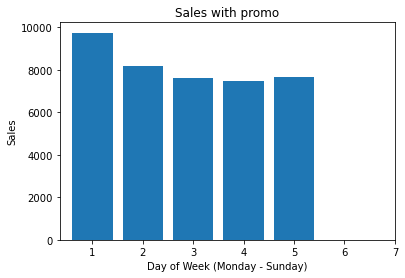

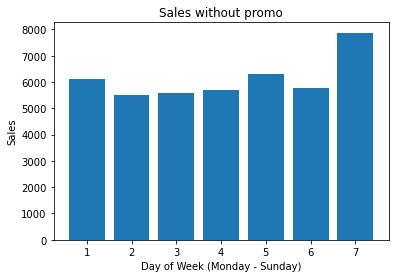

In [42]:
# Visualizing sales by weekday with and without promo - could there be a pattern?
promo_sales = no_null_sales.loc[no_null_sales.loc[:,'Promo'] == 1]
no_promo_sales = no_null_sales.loc[no_null_sales.loc[:,'Promo'] == 0]

sales_by_weekday_with_promo = promo_sales.groupby('DayOfWeek').mean().loc[:,'Sales'].sort_values(ascending=False)
plt.bar(height=sales_by_weekday_with_promo.values, x=sales_by_weekday_with_promo.index)
plt.ylabel('Sales')
plt.xlabel('Day of Week (Monday - Sunday)')
plt.title('Sales with promo')
plt.xticks(range(1,8))
plt.show()

sales_by_weekday_no_promo = no_promo_sales.groupby('DayOfWeek').mean().loc[:,'Sales'].sort_values(ascending=False)
plt.bar(height=sales_by_weekday_no_promo.values, x=sales_by_weekday_no_promo.index)
plt.ylabel('Sales')
plt.xlabel('Day of Week (Monday - Sunday)')
plt.title('Sales without promo')
plt.show()

In [43]:
# Monday's higher sales seem to only occur when there's also a promo happening
# Adding PromoMonday feature
# Seems it didn't help
rf_set = sample.drop(['Date', 'Customers'], axis = 1)
rf_set['Store'] = mean_encoder(rf_set, 'Store')
rf_set['StoreType'] = mean_encoder(rf_set, 'StoreType')
rf_set['Assortment'] = mean_encoder(rf_set, 'Assortment')
rf_set['StateHoliday'] = mean_encoder(rf_set, 'StateHoliday')
rf_set['PromoMonday'] = 0
rf_set.loc[(rf_set['Promo'] == 1) & (rf_set['DayOfWeek'] == 1), 'PromoMonday'] = 1
rf_set.loc[rf_set['Month'] != 12, 'Month'] = 0
rf_set.loc[rf_set['Month'] == 12, 'Month'] = 1
run_random_forest(rf_set)

16.465605491730216

## Outlier removal

In [44]:
def run_random_forest(rf_set, min_train_sales=None, max_train_sales=None):
    X = rf_set.drop('Sales', axis = 1)
    y = rf_set['Sales']
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    if min_train_sales:
        mask = y_train > min_train_sales
        X_train = X_train[mask]
        y_train = y_train[mask]
    if max_train_sales:
        mask = y_train < max_train_sales
        X_train = X_train[mask]
        y_train = y_train[mask]
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    actuals = np.array(y_test)
    return get_score(actuals, preds)

In [51]:
# Removing outliers with very low sales
rf_set = sample.drop(['Date', 'Customers'], axis = 1)
rf_set['Store'] = mean_encoder(rf_set, 'Store')
rf_set['StoreType'] = mean_encoder(rf_set, 'StoreType')
rf_set['Assortment'] = mean_encoder(rf_set, 'Assortment')
rf_set['StateHoliday'] = mean_encoder(rf_set, 'StateHoliday')
rf_set.loc[rf_set['Month'] != 12, 'Month'] = 0
rf_set.loc[rf_set['Month'] == 12, 'Month'] = 1

for min_train_sales in range(0,2000,200):
    score = run_random_forest(rf_set, min_train_sales=min_train_sales)
    print(f'Threshold: {min_train_sales}, Score: {score}')

Threshold: 0, Score: 16.464164531186846
Threshold: 200, Score: 16.464164531186846
Threshold: 400, Score: 16.464164531186846
Threshold: 600, Score: 16.460445731114365
Threshold: 800, Score: 16.444206154252505
Threshold: 1000, Score: 16.41346195932162
Threshold: 1200, Score: 16.41131359845359
Threshold: 1400, Score: 16.42050510682822
Threshold: 1600, Score: 16.452961685679437
Threshold: 1800, Score: 16.47789998702518


In [56]:
# Removing outliers with very high sales, didn't help
rf_set = sample.drop(['Date', 'Customers'], axis = 1)
rf_set['Store'] = mean_encoder(rf_set, 'Store')
rf_set['StoreType'] = mean_encoder(rf_set, 'StoreType')
rf_set['Assortment'] = mean_encoder(rf_set, 'Assortment')
rf_set['StateHoliday'] = mean_encoder(rf_set, 'StateHoliday')
rf_set.loc[rf_set['Month'] != 12, 'Month'] = 0
rf_set.loc[rf_set['Month'] == 12, 'Month'] = 1

for max_train_sales in range(15000,27000,1000):
    score = run_random_forest(rf_set, min_train_sales=1200, max_train_sales=max_train_sales)
    print(f'Threshold: {max_train_sales}, Score: {score}')

Threshold: 15000, Score: 17.72892416711049
Threshold: 16000, Score: 17.27083701205255
Threshold: 17000, Score: 16.94386581075713
Threshold: 18000, Score: 16.77633637007344
Threshold: 19000, Score: 16.60336802273872
Threshold: 20000, Score: 16.505730338162564
Threshold: 21000, Score: 16.492549505142204
Threshold: 22000, Score: 16.474920731894635
Threshold: 23000, Score: 16.461125417886084
Threshold: 24000, Score: 16.460868693959636
Threshold: 25000, Score: 16.474588182982295
Threshold: 26000, Score: 16.457119015736467


## Hyperparameter tuning

In [58]:
# Starting point

rf_set = sample.drop(['Date', 'Customers'], axis = 1)
rf_set['Store'] = mean_encoder(rf_set, 'Store')
rf_set['StoreType'] = mean_encoder(rf_set, 'StoreType')
rf_set['Assortment'] = mean_encoder(rf_set, 'Assortment')
rf_set.loc[:,'StateHoliday'] = rf_set.loc[:,'StateHoliday'].apply(lambda x: 0 if x=='0' else 1)
rf_set.loc[rf_set['Month'] != 12, 'Month'] = 0
rf_set.loc[rf_set['Month'] == 12, 'Month'] = 1

run_random_forest(rf_set, min_train_sales=1200)

16.408135800660187

In [62]:
# Run this is you have time. Right now we don't. 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

rf_set = sample.drop(['Date', 'Customers'], axis = 1)
rf_set['Store'] = mean_encoder(rf_set, 'Store')
rf_set['StoreType'] = mean_encoder(rf_set, 'StoreType')
rf_set['Assortment'] = mean_encoder(rf_set, 'Assortment')
rf_set['StateHoliday'] = mean_encoder(rf_set, 'StateHoliday')
rf_set.loc[rf_set['Month'] != 12, 'Month'] = 0
rf_set.loc[rf_set['Month'] == 12, 'Month'] = 1

rf = RandomForestRegressor(random_state=42)
parameters = {'max_depth':range(1,30, 3), 
              'n_estimators'=range(100,1000,100), 
              'min_samples_split'=range(1,15),
             'max_samples'=range(0.1,1, 0.1),
             'max_features'=range(2,12)}

scorer = make_scorer(get_score, greater_is_better=False)
clf = GridSearchCV(rf, parameters, scoring=scorer)
clf.fit(rf_set.drop('Sales', axis = 1), rf_set['Sales'])

KeyboardInterrupt: 

In [65]:
# Let's instead do a less fancy, manual approach, one hyperparameter at a time

rf_set = sample.drop(['Date', 'Customers'], axis = 1)
rf_set['Store'] = mean_encoder(rf_set, 'Store')
rf_set['StoreType'] = mean_encoder(rf_set, 'StoreType')
rf_set['Assortment'] = mean_encoder(rf_set, 'Assortment')
rf_set['StateHoliday'] = mean_encoder(rf_set, 'StateHoliday')
rf_set.loc[rf_set['Month'] != 12, 'Month'] = 0
rf_set.loc[rf_set['Month'] == 12, 'Month'] = 1

X = rf_set.drop('Sales', axis = 1)
y = rf_set['Sales']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
mask = y_train > 1200
X_train = X_train[mask]
y_train = y_train[mask]

for max_depth in range(1,30,3):
    rf = RandomForestRegressor(random_state=42, 
                               max_depth=max_depth)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    actuals = np.array(y_test)
    score = get_score(actuals, preds)
    print(f'Max depth: {max_depth}, Score: {score}')

Max depth: 1, Score: 35.053729551037286
Max depth: 4, Score: 22.023664800066967
Max depth: 7, Score: 18.982545309394997
Max depth: 10, Score: 17.321307569827795
Max depth: 13, Score: 16.136174441031258
Max depth: 16, Score: 15.827152639388968
Max depth: 19, Score: 16.12117862371878
Max depth: 22, Score: 16.337991385287427
Max depth: 25, Score: 16.395461235008042
Max depth: 28, Score: 16.406881348013336


In [82]:
rf_set = sample.drop(['Date', 'Customers'], axis = 1)
rf_set['Store'] = mean_encoder(rf_set, 'Store')
rf_set['StoreType'] = mean_encoder(rf_set, 'StoreType')
rf_set['Assortment'] = mean_encoder(rf_set, 'Assortment')
rf_set['StateHoliday'] = mean_encoder(rf_set, 'StateHoliday')
rf_set.loc[rf_set['Month'] != 12, 'Month'] = 0
rf_set.loc[rf_set['Month'] == 12, 'Month'] = 1

X = rf_set.drop('Sales', axis = 1)
y = rf_set['Sales']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
mask = y_train > 1200
X_train = X_train[mask]
y_train = y_train[mask]

for n_estimators in range(100,2000,100):
    rf = RandomForestRegressor(random_state=42, 
                               max_depth=16, 
                               n_estimators=n_estimators)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    actuals = np.array(y_test)
    score = get_score(actuals, preds)
    print(f'n_estimators: {n_estimators}, Score: {score}')

n_estimators: 100, Score: 15.827152639388968
n_estimators: 200, Score: 15.822192269019823
n_estimators: 300, Score: 15.816427777231594
n_estimators: 400, Score: 15.815198291883357
n_estimators: 500, Score: 15.813772377754647
n_estimators: 600, Score: 15.814249431073502
n_estimators: 700, Score: 15.811588931838969
n_estimators: 800, Score: 15.810451386348724
n_estimators: 900, Score: 15.809870122305124
n_estimators: 1000, Score: 15.809141806787293
n_estimators: 1100, Score: 15.808657327451666
n_estimators: 1200, Score: 15.809362133066436
n_estimators: 1300, Score: 15.808930425451443
n_estimators: 1400, Score: 15.809039980183515
n_estimators: 1500, Score: 15.809099907414055
n_estimators: 1600, Score: 15.808404889268227
n_estimators: 1700, Score: 15.80844967321532
n_estimators: 1800, Score: 15.808292847740855
n_estimators: 1900, Score: 15.808049996408263


In [83]:
rf_set = sample.drop(['Date', 'Customers'], axis = 1)
rf_set['Store'] = mean_encoder(rf_set, 'Store')
rf_set['StoreType'] = mean_encoder(rf_set, 'StoreType')
rf_set['Assortment'] = mean_encoder(rf_set, 'Assortment')
rf_set['StateHoliday'] = mean_encoder(rf_set, 'StateHoliday')
rf_set.loc[rf_set['Month'] != 12, 'Month'] = 0
rf_set.loc[rf_set['Month'] == 12, 'Month'] = 1

X = rf_set.drop('Sales', axis = 1)
y = rf_set['Sales']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
mask = y_train > 1200
X_train = X_train[mask]
y_train = y_train[mask]

for min_samples_split in range(8,22):
    rf = RandomForestRegressor(random_state=42, 
                               max_depth=16, 
                               n_estimators=1900, 
                               min_samples_split=min_samples_split)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    actuals = np.array(y_test)
    score = get_score(actuals, preds)
    print(f'min_samples_split: {min_samples_split}, Score: {score}')

min_samples_split: 8, Score: 15.669512057323344
min_samples_split: 9, Score: 15.65232971176269
min_samples_split: 10, Score: 15.63778788074124
min_samples_split: 11, Score: 15.628177780772713
min_samples_split: 12, Score: 15.621664902020429
min_samples_split: 13, Score: 15.617502794614706
min_samples_split: 14, Score: 15.616240703505968
min_samples_split: 15, Score: 15.616175154907225
min_samples_split: 16, Score: 15.618172003432019
min_samples_split: 17, Score: 15.621691343202947
min_samples_split: 18, Score: 15.627182822284446
min_samples_split: 19, Score: 15.632597924980438
min_samples_split: 20, Score: 15.640142700454058
min_samples_split: 21, Score: 15.648523840403463


In [84]:
rf_set = sample.drop(['Date', 'Customers'], axis = 1)
rf_set['Store'] = mean_encoder(rf_set, 'Store')
rf_set['StoreType'] = mean_encoder(rf_set, 'StoreType')
rf_set['Assortment'] = mean_encoder(rf_set, 'Assortment')
rf_set['StateHoliday'] = mean_encoder(rf_set, 'StateHoliday')
rf_set.loc[rf_set['Month'] != 12, 'Month'] = 0
rf_set.loc[rf_set['Month'] == 12, 'Month'] = 1

X = rf_set.drop('Sales', axis = 1)
y = rf_set['Sales']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
mask = y_train > 1200
X_train = X_train[mask]
y_train = y_train[mask]

for max_samples in np.array(range(1,10))/10:
    rf = RandomForestRegressor(random_state=42, 
                               max_depth=16, 
                               n_estimators=1900, 
                               min_samples_split=15,
                               max_samples=max_samples)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    actuals = np.array(y_test)
    score = get_score(actuals, preds)
    print(f'max_samples: {max_samples}, Score: {score}')

max_samples: 0.1, Score: 16.809401675585978
max_samples: 0.2, Score: 16.148742678042698
max_samples: 0.3, Score: 15.87135316698853
max_samples: 0.4, Score: 15.740502927434033
max_samples: 0.5, Score: 15.67351143734294
max_samples: 0.6, Score: 15.637919646247097
max_samples: 0.7, Score: 15.620574304135154
max_samples: 0.8, Score: 15.611637859532856
max_samples: 0.9, Score: 15.614364738608534


In [85]:
rf_set = sample.drop(['Date', 'Customers'], axis = 1)
rf_set['Store'] = mean_encoder(rf_set, 'Store')
rf_set['StoreType'] = mean_encoder(rf_set, 'StoreType')
rf_set['Assortment'] = mean_encoder(rf_set, 'Assortment')
rf_set['StateHoliday'] = mean_encoder(rf_set, 'StateHoliday')
rf_set.loc[rf_set['Month'] != 12, 'Month'] = 0
rf_set.loc[rf_set['Month'] == 12, 'Month'] = 1

X = rf_set.drop('Sales', axis = 1)
y = rf_set['Sales']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
mask = y_train > 1200
X_train = X_train[mask]
y_train = y_train[mask]

for max_features in range(2,11):
    rf = RandomForestRegressor(random_state=42, 
                               max_depth=16, 
                               n_estimators=1900, 
                               min_samples_split=15,
                               max_samples=0.7,
                               max_features=max_features)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    actuals = np.array(y_test)
    score = get_score(actuals, preds)
    print(f'max_features: {max_features}, Score: {score}')

max_features: 2, Score: 16.202543796879386
max_features: 3, Score: 15.942325802672661
max_features: 4, Score: 15.805847511875395
max_features: 5, Score: 15.711712017603404
max_features: 6, Score: 15.658001039100679
max_features: 7, Score: 15.628403376468514
max_features: 8, Score: 15.621114876281935
max_features: 9, Score: 15.617499483460778
max_features: 10, Score: 15.620574304135154


In [86]:
rf_set = sample.drop(['Date', 'Customers'], axis = 1)
rf_set['Store'] = mean_encoder(rf_set, 'Store')
rf_set['StoreType'] = mean_encoder(rf_set, 'StoreType')
rf_set['Assortment'] = mean_encoder(rf_set, 'Assortment')
rf_set['StateHoliday'] = mean_encoder(rf_set, 'StateHoliday')
rf_set.loc[rf_set['Month'] != 12, 'Month'] = 0
rf_set.loc[rf_set['Month'] == 12, 'Month'] = 1

X = rf_set.drop('Sales', axis = 1)
y = rf_set['Sales']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
mask = y_train > 1200
X_train = X_train[mask]
y_train = y_train[mask]

for max_depth in range(11,24):
    rf = RandomForestRegressor(random_state=42, 
                               max_depth=max_depth, 
                               n_estimators=1900, 
                               min_samples_split=15,
                               max_samples=0.7,
                               max_features=8)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    actuals = np.array(y_test)
    score = get_score(actuals, preds)
    print(f'max_depth: {max_depth}, Score: {score}')

max_depth: 11, Score: 16.886527646131672
max_depth: 12, Score: 16.49854707110127
max_depth: 13, Score: 16.160911068155055
max_depth: 14, Score: 15.900003764382411
max_depth: 15, Score: 15.724334946978594
max_depth: 16, Score: 15.621114876281935
max_depth: 17, Score: 15.563574029893312
max_depth: 18, Score: 15.53825918238012
max_depth: 19, Score: 15.531173920081578
max_depth: 20, Score: 15.527580448668061
max_depth: 21, Score: 15.528390463349304
max_depth: 22, Score: 15.528866551919037
max_depth: 23, Score: 15.529231115067386


In [87]:
rf_set = sample.drop(['Date', 'Customers'], axis = 1)
rf_set['Store'] = mean_encoder(rf_set, 'Store')
rf_set['StoreType'] = mean_encoder(rf_set, 'StoreType')
rf_set['Assortment'] = mean_encoder(rf_set, 'Assortment')
rf_set['StateHoliday'] = mean_encoder(rf_set, 'StateHoliday')
rf_set.loc[rf_set['Month'] != 12, 'Month'] = 0
rf_set.loc[rf_set['Month'] == 12, 'Month'] = 1

X = rf_set.drop('Sales', axis = 1)
y = rf_set['Sales']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
mask = y_train > 1200
X_train = X_train[mask]
y_train = y_train[mask]

for n_estimators in range(1500,3500,100):
    rf = RandomForestRegressor(random_state=42, 
                               max_depth=16, 
                               n_estimators=n_estimators, 
                               min_samples_split=15,
                               max_samples=0.7,
                               max_features=8)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    actuals = np.array(y_test)
    score = get_score(actuals, preds)
    print(f'n_estimators: {n_estimators}, Score: {score}')

n_estimators: 1500, Score: 15.623367142610574
n_estimators: 1600, Score: 15.621170094923539
n_estimators: 1700, Score: 15.620831295670346
n_estimators: 1800, Score: 15.620588943922398
n_estimators: 1900, Score: 15.621114876281935
n_estimators: 2000, Score: 15.6208770017953
n_estimators: 2100, Score: 15.621028412951665
n_estimators: 2200, Score: 15.62070280429101
n_estimators: 2300, Score: 15.619982194911865
n_estimators: 2400, Score: 15.619953181880991
n_estimators: 2500, Score: 15.618920886515056
n_estimators: 2600, Score: 15.618595986878152
n_estimators: 2700, Score: 15.61944582954539
n_estimators: 2800, Score: 15.619341015917547
n_estimators: 2900, Score: 15.619312725028061
n_estimators: 3000, Score: 15.618485230833212
n_estimators: 3100, Score: 15.618521988444344
n_estimators: 3200, Score: 15.61861703928767
n_estimators: 3300, Score: 15.618591882080588
n_estimators: 3400, Score: 15.618548142683114


In [90]:
# Combining wisdom from the previous experiments
rf_set = sample.drop(['Date', 'Customers'], axis = 1)
rf_set['Store'] = mean_encoder(rf_set, 'Store')
rf_set['StoreType'] = mean_encoder(rf_set, 'StoreType')
rf_set['Assortment'] = mean_encoder(rf_set, 'Assortment')
rf_set['StateHoliday'] = mean_encoder(rf_set, 'StateHoliday')
rf_set.loc[rf_set['Month'] != 12, 'Month'] = 0
rf_set.loc[rf_set['Month'] == 12, 'Month'] = 1

X = rf_set.drop('Sales', axis = 1)
y = rf_set['Sales']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
mask = y_train > 1200
X_train = X_train[mask]
y_train = y_train[mask]


rf = RandomForestRegressor(random_state=42, 
                               max_depth=20, 
                               n_estimators=3000, 
                               min_samples_split=15,
                               max_samples=0.7,
                               max_features=8)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)
actuals = np.array(y_test)
score = get_score(actuals, preds)
print(f'Score: {score}')

Score: 15.527010984251191


Fair enough, let's consider ourselves done fiddling and train a model on the full dataset! We'll do that in the next notebook: train_notebook.ipynb